```
                            (#%(//***,.                                         
                          %@&&&&&&&&%&&&&&&#                                    
                       ,@@@@@&&%#(/*,,*(#%&&@&. ,#%&&&&&@&&#,                   
                      %&@@@@&&%(*,.....,*(#%&&@&&@@@@@&%&&@@@@@@@&              
                     /%@&@@@&%%(/******/(##%&&@@&@@&#((////(((#%&@@@@           
            /&@@@@@@&%@@@&@@&%%###(((#%%%&&&&&&&##%&#///*/(&@@@&%%&@@@#         
        (@@@@&/@@@@@@@@#%@@@@&&%%%%*/#&%#%&&&@@@@@@&#//&%                       
      @@@&&((##(%&@@@@@@&%@%@&@(%#%%%%%%,./(/.(/&((&@.                          
    &@@%//***,****(#%&@@@@@@@@%&*/#/.*(///*,//.#%%,&                            
   &@@(/**,,,,,,,,,,/&&@@@@@@@@&. ((/  /#%####%&&&(&                            
  &@@#(#%@@@&*        %@@@@@@@@&*#%&/%((((%&&%%&&@@&                            
 .@@@@@                   (#&&&&@@@@&&&//,,,(/(##/                             ,
 .@&                      %@@&&(%(,*(/,..*(#/(%#((#%(.                       ,.@
  .                   .(&%&@@@&%##**(#@/,  %@%%@#/#,%&&&                    ,.@@
                  *%&@@&(/#%&@&@@@#(.. .,,*/*&@@@///,%%&@%                 ,.@@@
                &@@@&&&%&@*,(#@@&@@@@@@(. ,&@&%@@&(,%,&&@@/              .,(@@@@
               &@@%%(/#%&@@,,*(%@%@@@@@@@&##/(%&&%&#/#&@@@&           ..*.@@@@@@
               @@@&%%%&&&@@@,%,&%&&&@@&%((&(%&@@@@%@#&&&&&@&.        ..*,@@@@@@@
               #@@@&%(((%&&@%#,(%%@@&@&%*@@@@@@@@@@@%@&&/(#&&*...  ...*,@@@@@@@@
               .%&&&(  ,(%&&@&*(&&&&&%/,&@&(@@&%&@@@&@@@&**#&&&,. ../*(@@@@@@@@&
         .......%&@@@&&&@@@@@&/&&&%%#/(&@&(%%@%%%%@&@&&@@&&./#%%* ./*&@@@@@@@@@@
##############(,*@@&&&&&&&@@@&&@@@@&#*#&&@&#%&%%#%%%@@&%@&&&#,(%&%*/@@@@@@@@@@@@
##############(*.@@@%%#&&&@@@&@&%#(*#&@&#(#&&%&&##(,%&&&%%&@&&&@%/&@@@@@@@@@@@@@
((##########(((/.%@@@#(#%&&@&&&%(*,(#%%&&(%#%#%&%#(,.#%&@@&@(,,%*#@@@@@@@@@@@@@@
//(##########(,...@@@@@&&%@@&&%#((#%&&&%&%%&%%%&&%    ##%&@@@@/*&%@@@@@@@@@@@@@@
(###########((/,,.(@@@&/,(@&&&&%%&&&&&%%&&&%%%%&&........%%%%**@@@@@@@@&@@@@@@@@
###(,,,,*/(((((*,(%@@@@@@@@&&&&&&&@&%/&&%#%%%%&&#./#(*//(((%*/@@@@@@@@@@@@@@@@@@
,*###(((((((((((#&&@@&@@@@&@@&&@@&&(&#**,**,,,********//((%*#@@@@@@@@@@@@@@@@@@@
///////////////(#%&&@@&@@@@@@@@@&(**,*,,,,,,,,,*%//%##(##(*&@@@@@@@@@@@@@@@@@@@@
///////////////////(##%&@@@@@@@&%******&/(##%###########/*@@@@@@@@@@@@@@@@@@@@@@
////////////////////((#%%%%&@@@&&#,(/#%*,*/*.&%########//@@@@@@@@@@@@@@@@@@@@@@&
%%(*/////////////////////(///////#@@@@@@@@/(%*,*/(.,&&*(@@@@@@@@@@@@@@@@@@@@@@(/
```
# Goblin Mode

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import copy
import json
import math
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from time import time
from IPython.display import clear_output
from HelperFunctions import getFeatureVector, plot

In [3]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [4]:
myPath = os.getcwd()

myYogaPath = os.path.join(myPath, 'yoga')
myDataPath = os.path.join(myPath, 'data')

myYogaFolders = os.listdir(myYogaPath)
myDataFiles = os.listdir(myDataPath)

In [15]:
def yogaToVector():
    
    for folder in myYogaFolders:

        print(folder)
        allVectors = []

        posePath = os.path.join(myYogaPath, folder)
        myYogaImages = os.listdir(posePath)

        for imageName in myYogaImages:

            imagePath = os.path.join(posePath, imageName)
            
            imageRGB = None
            try:
                image = cv2.imread(imagePath)
                imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except:
                continue

            results = pose.process(imageRGB)
            if results.pose_landmarks:
                featureVector = getFeatureVector(results.pose_landmarks.landmark)
                allVectors.append(featureVector)

        np.save(f'data/{folder}.npy', np.array(allVectors, dtype=float), allow_pickle=True)

def read_data():

    allVectors = {}
    for file in myDataFiles:
        posePath = os.path.join(myDataPath, file)
        allVectors[file[:-5]] = np.load(posePath, allow_pickle=True)

    return allVectors

def align_pose(pose):

    # Find the midpoint between the left and right hips
    hips_center = (pose[13][:3] + pose[14][:3]) / 2

    print('hip center', hips_center)

    # Find the midpoint between the left and right shoulders
    shoulders_center = (pose[1][:3] + pose[2][:3]) / 2

    print('shoulders_center', shoulders_center)

    temp = 90 * (math.pi/180)


    # Compute the offset needed to move the hips center below the shoulders center in the z-axis
    offset = np.array([0, temp - hips_center[1], temp - hips_center[2]])

    # Convert polar coordinates to Cartesian coordinates
    r = pose[:, 0]
    theta = pose[:, 1]
    phi = pose[:, 2]

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    cartesian = np.vstack((x, y, z)).T

    # Create a matrix to apply the translation to all points
    translate_mat = np.tile(offset, (len(cartesian), 1))
    print('translate_mat')
    print(translate_mat)

    # Apply the translation to all points
    aligned_cartesian = cartesian + translate_mat

    # Convert back to polar coordinates
    aligned_r = np.linalg.norm(aligned_cartesian, axis=1)
    aligned_phi = np.arccos(aligned_cartesian[:, 2] / aligned_r)
    aligned_theta = np.arctan2(aligned_cartesian[:, 1], aligned_cartesian[:, 0])

    # Combine the polar coordinates back into a single array
    aligned_pose = np.vstack((aligned_r, aligned_theta, aligned_phi)).T

    return aligned_pose

def view_pose(pose, allVectors): # Maybe make this a member function of class

    for thisPose in allVectors:

        if thisPose != pose:
            continue

        for index, vector in enumerate(allVectors[thisPose]):

            vector.shape = 23, 3
            fixedPose = align_pose(vector)

            print(index)

            print('original')
            plot(vector)
            print(vector)

            print()
            
            print('fixed')
            plot(fixedPose)
            print(fixedPose)
            
            # Don't print all at once, step through
            check = input('press enter to esc')
            if check == '':
                break
            
            clear_output(wait=True)

In [6]:
allVectors = read_data()

In [ ]:
# scale of 0.4 is sometimes changed, some poses look really small ???
# make sure center between hips is directly below chest, move all point accordingly.

hip center [0.31033079 0.69057388 3.40444517]
shoulders_center [0.09989107 1.57079633 3.14159265]
translate_mat
[[ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.83364885]
 [ 0.          0.88022245 -1.8

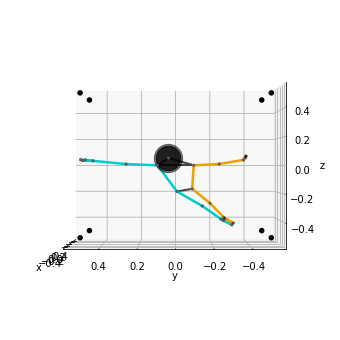

[[0.195529   2.80184808 0.64257546]
 [0.09989107 1.5669304  1.57079633]
 [0.09989107 1.57466226 4.71238898]
 [0.27641725 1.75116769 1.53828249]
 [0.24340113 1.74331995 4.75305556]
 [0.48575993 1.96106478 1.50003944]
 [0.40199774 1.97235913 4.81767645]
 [0.54308397 1.96265777 1.50299127]
 [0.42620979 2.01391276 4.87869232]
 [0.56976627 2.02468158 1.49212518]
 [0.44153236 2.08646837 4.88324916]
 [0.53107175 1.97272564 1.49093972]
 [0.420844   2.00893889 4.85600932]
 [0.29091134 0.73198768 3.17792481]
 [0.32975024 0.64916007 3.63096554]
 [0.40694327 0.98084776 3.60169534]
 [0.46497813 0.83954084 3.74390341]
 [0.61354833 0.90827345 3.71063707]
 [0.65736757 0.83004391 3.75355028]
 [0.63129624 0.91416241 3.72157062]
 [0.66989086 0.83241488 3.75066558]
 [0.61549257 1.09590264 3.76281469]
 [0.64576238 1.00564995 3.79053513]]

fixed


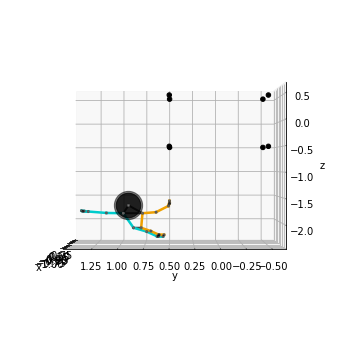

[[1.91572009 1.69039959 2.63716241]
 [2.07915591 1.57040232 2.65071578]
 [1.9927836  1.57030145 2.73924565]
 [2.15846764 1.61379164 2.57801843]
 [1.93345019 1.50571859 2.80312221]
 [2.24409279 1.70868998 2.5010924 ]
 [1.86974261 1.27472878 2.85109233]
 [2.27565991 1.71953345 2.48094756]
 [1.84159485 1.22516394 2.84856593]
 [2.2795121  1.74799658 2.47310584]
 [1.84128317 1.16667293 2.84073024]
 [2.26305285 1.72110079 2.48411214]
 [1.85183399 1.23298996 2.84953394]
 [2.29682614 1.57979823 2.75160743]
 [2.26896208 1.7265171  2.78307334]
 [2.31851392 1.7076304  2.81812443]
 [2.32663202 1.82248591 2.83310996]
 [2.43928689 1.8879359  2.87097582]
 [2.46005202 1.97152928 2.87280549]
 [2.44740166 1.90602398 2.87619234]
 [2.47017509 1.97879307 2.87525375]
 [2.40634647 1.85457737 2.89601263]
 [2.42088048 1.93355813 2.89583818]]


In [16]:
view_pose('Side_Plank_Pose_or_Vasisthasana', allVectors)

In [2]:
# Ignore this

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.get_device_name(0)

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)

    # x represents our data
    def forward(self, x):
      
      x = self.conv1(x)
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      x = F.max_pool2d(x, 2)
      x = self.dropout1(x)

      x = torch.flatten(x, 1)
      
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)